In [1]:
from sklearn import datasets, tree, metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
##### ustawienia
time_multiplicator = 1
seed = 244810
samples = 2410
#samples = 300

In [3]:
def standarize(arr):
    for col in range(arr.shape[1]):
        xmean = np.mean( arr[:,col])
        xstd = np.std( arr[:,col])
        arr[:,col] = (arr[:,col] - xmean)/xstd
    return arr    
    
def normalize(arr):
    for col in range(arr.shape[1]):
        xmin = min( arr[:,col])
        xmax = max( arr[:,col])
        arr[:,col] = (arr[:,col] - xmin )/(xmax-xmin)
    
    return arr        

In [4]:
def compare_model(sk, my,X_tr, X_te, y_tr, y_te, roc=True ):
    mycmap = "coolwarm"
    sk_time = time.perf_counter()
    for i in range(time_multiplicator):
        sk.fit(X_tr,y_tr)
    sk_time = (time.perf_counter() - sk_time)/time_multiplicator

    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.fit(X_tr,y_tr)
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    
    my_pred = my.predict(X_te)
    sk_pred = sk.predict(X_te)
    
    #graph
    fig, axs = plt.subplots(3, 2,figsize=(12,18))

    mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]
    sk_predict = sk.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
    my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
    
    axs[0,0].set_title("Sklearn")
    axs[0,0].contourf(mesh, mesh.T, sk_predict, alpha=0.2,cmap=mycmap)
    axs[0,0].scatter(X_te[:, 0], X_te[:, 1],cmap=mycmap, c=y_te, marker="o", alpha=0.5)
    axs[0,0].scatter(X_tr[:, 0], X_tr[:, 1],cmap=mycmap, c=y_tr, marker="+", alpha=0.2)

    axs[0,1].set_title("Własna implementacja")
    axs[0,1].contourf(mesh, mesh.T, my_predict, alpha=0.2,cmap=mycmap)
    axs[0,1].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5,cmap=mycmap)
    axs[0,1].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2,cmap=mycmap)
    
    #confusion matrix
    sk_cm = metrics.confusion_matrix(y_te, sk_pred)
    sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
    sk_disp.plot(ax=axs[1,0] ,cmap="plasma")
    # sk_disp.im_.colorbar.remove()

    my_cm = metrics.confusion_matrix(y_te, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[1,1] ,cmap="plasma")
    # my_disp.im_.colorbar.remove()
    my_disp.ax_.set_ylabel('')
    
    if roc:
        #roc
        fpr, tpr, thresholds = metrics.roc_curve(y_te, sk.predict(X_test))
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
        display.plot(ax=axs[2,0])

        fpr, tpr, thresholds = metrics.roc_curve(y_te, my.predict(X_test))
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
        display.plot(ax=axs[2,1])
    
    #metryki
    print('              | Sklearn | Własna')
    print('--------------+---------+----------')
    print(f'Czułość       |{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]):9.4f}|{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):.4f}')
    print(f'Specyficzność |{sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]):9.4f}|{my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]):.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(sk_pred, y_test):9.4f}|{metrics.accuracy_score(my_pred, y_test):.4f}')
    print(f'Czas wykonania|{sk_time:9.2E}|{my_time:.2E}')
    print(f'BACC          |{metrics.balanced_accuracy_score(sk_pred, y_test,adjusted=False):9.4f}|{metrics.balanced_accuracy_score(my_pred, y_test,adjusted=False):.4f}')

In [5]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        self.value = value

In [6]:
class myTree():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None

        self.min_samples = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, X, Y, curr_depth=0):
        num_samples, num_features = np.shape(X)

        if num_samples>=self.min_samples and curr_depth<=self.max_depth:
            best_split = self.get_best_split(X, Y, num_samples, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["X_left"],best_split["Y_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["X_right"],best_split["Y_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def get_best_split(self, X, Y, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")
        
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                X_left, Y_left, X_right, Y_right = self.split(X, Y, feature_index, threshold)
                if len(X_left)>0 and len(X_right)>0:
                    curr_info_gain = self.information_gain(Y, Y_left, Y_right)
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["X_left"] = X_left
                        best_split["X_right"] = X_right
                        best_split["Y_left"] = Y_left
                        best_split["Y_right"] = Y_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split
    
    def split(self, X, Y, feature_index, threshold):
        X_left = []
        Y_left = []
        X_right = []
        Y_right = []
        for i, row in enumerate(X):
            if row[feature_index] <= threshold:
                X_left.append(row)
                Y_left.append(Y[i])
            else:
                X_right.append(row)
                Y_right.append(Y[i])
        
        return  np.array(X_left), np.array(Y_left), np.array(X_right), np.array(Y_right)
    
    def information_gain(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy    
    
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def fit(self, X, Y):
        self.root = self.build_tree(X,Y)
    
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [7]:
X, y  = datasets.make_classification(n_features=2, n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = normalize(X_train)
X_test = normalize(X_test)

## 1 klaster na klasę
### Głębokość nieograniczona

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.8735|0.8729
Specyficzność |   0.4917|0.5024
Skuteczność   |   0.8734|0.8589
Czas wykonania| 3.71E-03|1.81E+01
BACC          |   0.8734|0.8592


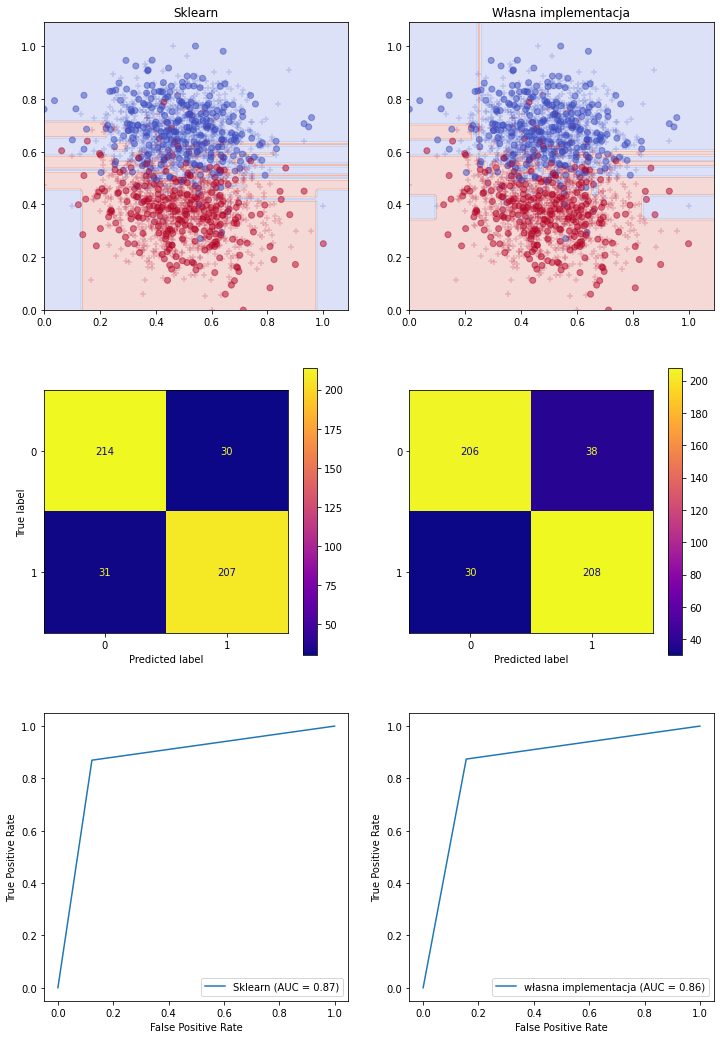

In [8]:
my_model = myTree(min_samples_split=3, max_depth=5000)
sk_model = tree.DecisionTreeClassifier()
compare_model(sk_model, my_model ,X_train, X_test, y_train, y_test)

### Głębokość = ilości cech

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9212|0.8826
Specyficzność |   0.4966|0.4705
Skuteczność   |   0.9149|0.9129
Czas wykonania| 1.75E-03|1.19E+01
BACC          |   0.9149|0.9161


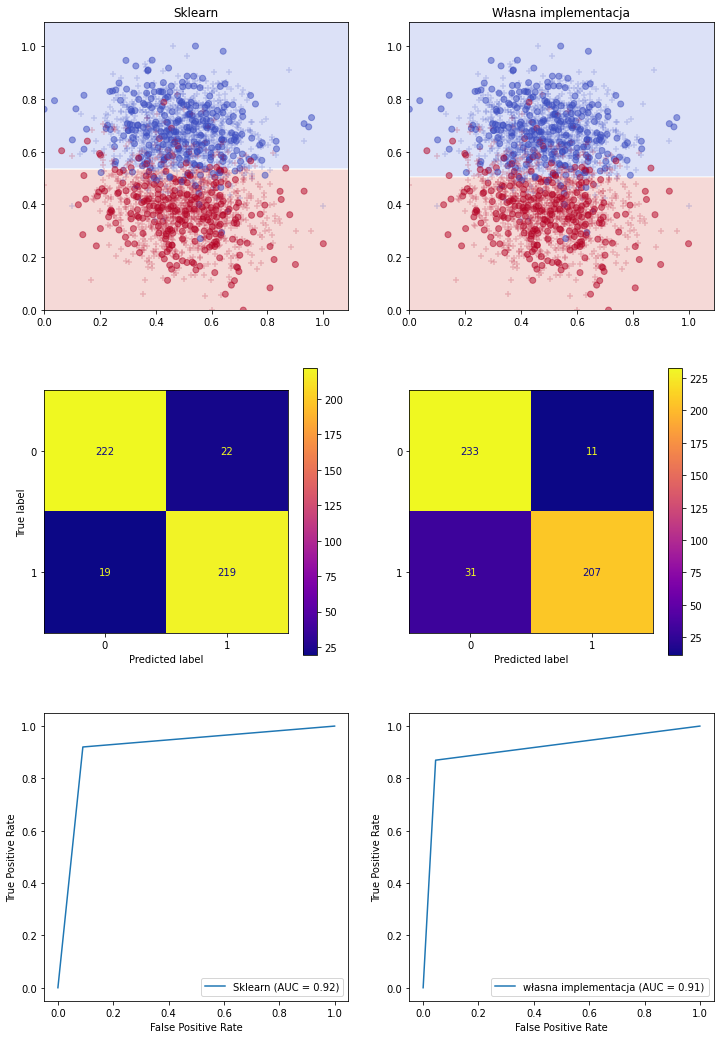

In [9]:
my_model = myTree(min_samples_split=3, max_depth=2)
sk_model = tree.DecisionTreeClassifier(max_depth=2)
compare_model(sk_model, my_model ,X_train, X_test, y_train, y_test)

### Głębokość = ilości klastrów

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9212|0.8826
Specyficzność |   0.4966|0.4705
Skuteczność   |   0.9149|0.9129
Czas wykonania| 1.10E-03|9.88E+00
BACC          |   0.9149|0.9161


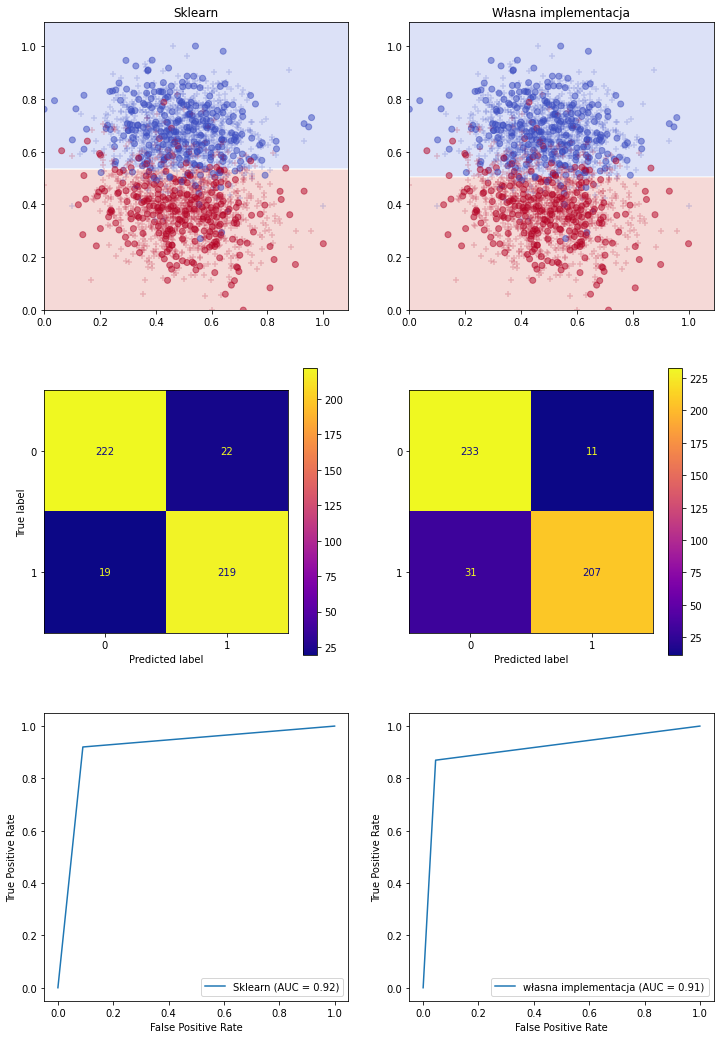

In [10]:
my_model = myTree(min_samples_split=3, max_depth=1)
sk_model = tree.DecisionTreeClassifier(max_depth=1)
compare_model(sk_model, my_model ,X_train, X_test, y_train, y_test)

## 2 klastry na klasę
### Głębokość nieograniczona

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9493|0.9515
Specyficzność |   0.5242|0.5124
Skuteczność   |   0.8983|0.9191
Czas wykonania| 3.56E-03|1.77E+01
BACC          |   0.9030|0.9209


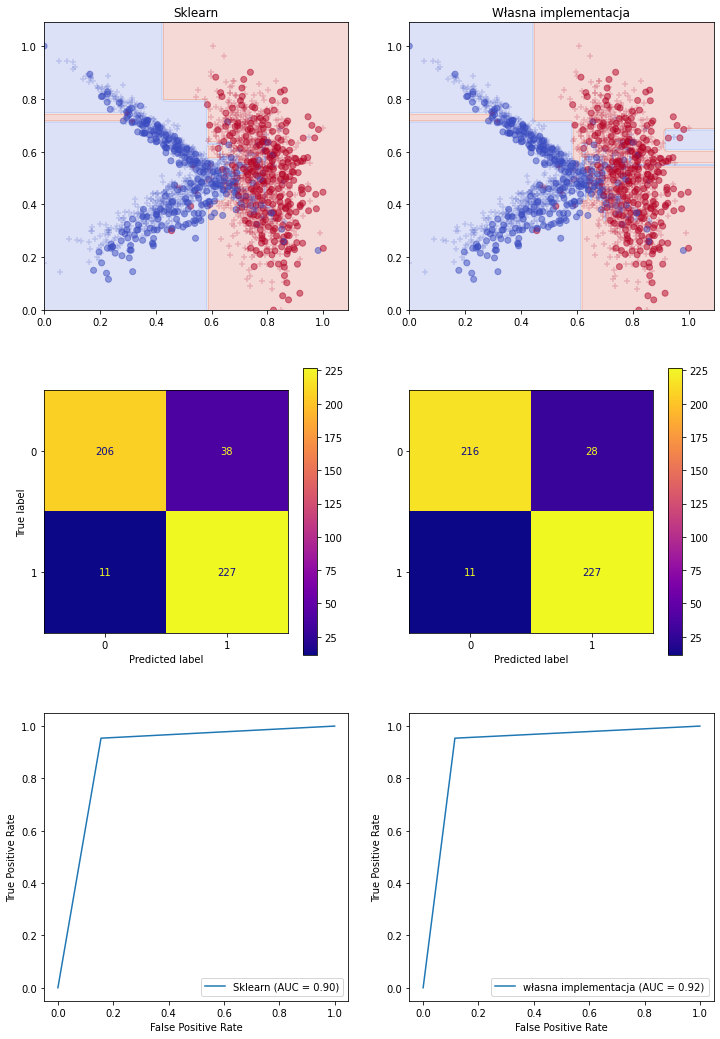

In [11]:
my_model2 = myTree(min_samples_split=3, max_depth=5000)
sk_model2 = tree.DecisionTreeClassifier()
X, y  = datasets.make_classification(n_features=2, n_clusters_per_class=2,n_redundant=0,
                                     n_samples=samples,
                                     random_state=seed, class_sep=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = normalize(X_train)
X_test = normalize(X_test)
compare_model(sk_model2, my_model2 ,X_train, X_test, y_train, y_test)

### Głębokość = ilości cech = ilość klastrów

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9623|0.9782
Specyficzność |   0.5300|0.5098
Skuteczność   |   0.9004|0.9481
Czas wykonania| 1.48E-03|1.24E+01
BACC          |   0.9071|0.9496


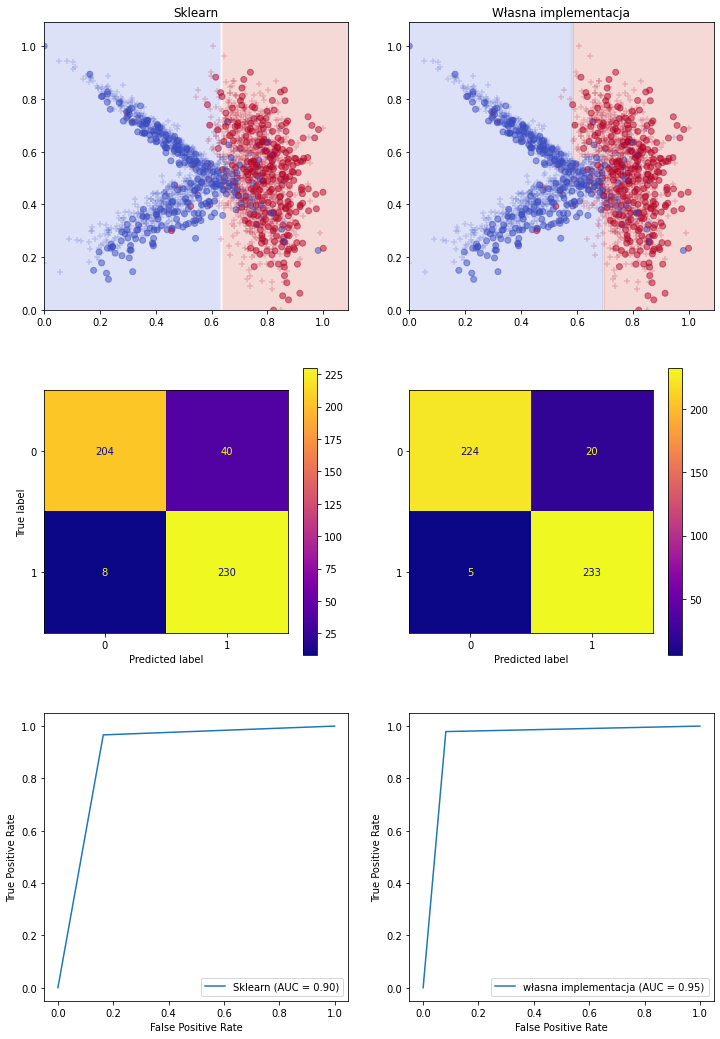

In [12]:
my_model2 = myTree(min_samples_split=3, max_depth=2)
sk_model2 = tree.DecisionTreeClassifier(max_depth=2)
compare_model(sk_model2, my_model2 ,X_train, X_test, y_train, y_test)

## Moons
### Głębokość nieograniczona

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9876|0.9958
Specyficzność |   0.5000|0.5021
Skuteczność   |   0.5228|0.5228
Czas wykonania| 2.35E-03|1.55E+01
BACC          |   0.5228|0.5228


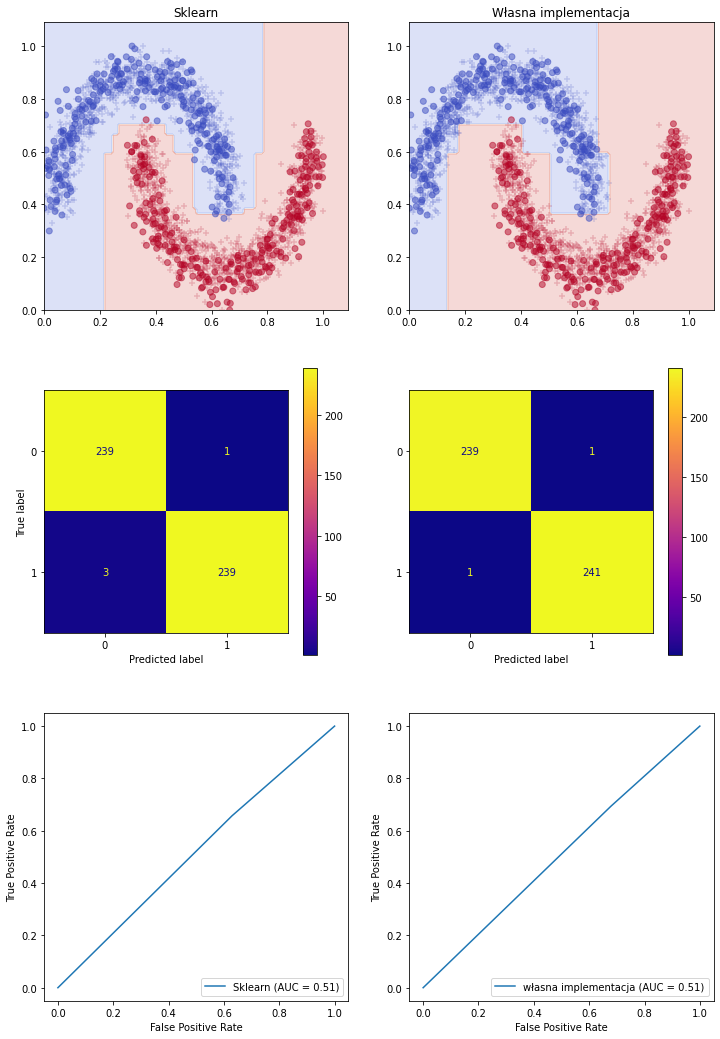

In [13]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.1, random_state=seed)

M_train, M_test, mc_train, mc_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)

M_train = normalize(M_train)
M_test = normalize(M_test)

my_model3 = myTree(min_samples_split=3, max_depth=5000)
sk_model3 = tree.DecisionTreeClassifier()

compare_model(sk_model3, my_model3 ,M_train, M_test, mc_train, mc_test)

### Głębokość = liczbie cech

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9644|0.9644
Specyficzność |   0.5188|0.5188
Skuteczność   |   0.5207|0.5207
Czas wykonania| 1.33E-03|1.29E+01
BACC          |   0.5213|0.5213


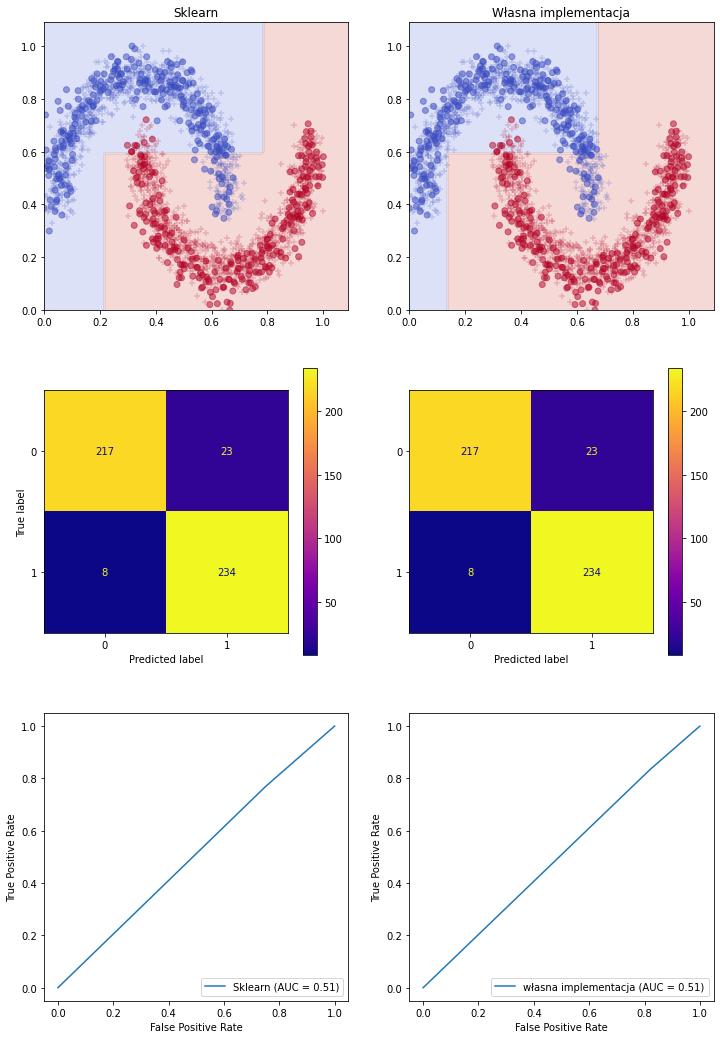

In [14]:
my_model3 = myTree(min_samples_split=3, max_depth=2)
sk_model3 = tree.DecisionTreeClassifier(max_depth=2)

compare_model(sk_model3, my_model3 ,M_train, M_test, mc_train, mc_test)

# Wnioski
- większa głębokość dzrzewa dezycyjnego zwiększa szansę na prawidłową klasyfikację nieznanych próbek
- własna implementacja dawał lepsze wyniki klasyfikacji jednak czas uczenia był znacznie dłuższy(1000x)


# HTRU2

In [15]:
htru = pd.read_csv('HTRU_2.csv', delimiter = ',')

In [16]:
htru.columns =['mean_itg','std','kurtosis','skewness','mean_dm','std_dm','kurtosis_dm','skewness_dm','class']

In [17]:
htru

mean_itg        std  kurtosis  skewness     mean_dm     std_dm  \
0      102.507812  58.882430  0.465318 -0.515088    1.677258  14.860146   
1      103.015625  39.341649  0.323328  1.051164    3.121237  21.744669   
2      136.750000  57.178449 -0.068415 -0.636238    3.642977  20.959280   
3       88.726562  40.672225  0.600866  1.123492    1.178930  11.468720   
4       93.570312  46.698114  0.531905  0.416721    1.636288  14.545074   
...           ...        ...       ...       ...         ...        ...   
17892  136.429688  59.847421 -0.187846 -0.738123    1.296823  12.166062   
17893  122.554688  49.485605  0.127978  0.323061   16.409699  44.626893   
17894  119.335938  59.935939  0.159363 -0.743025   21.430602  58.872000   
17895  114.507812  53.902400  0.201161 -0.024789    1.946488  13.381731   
17896   57.062500  85.797340  1.406391  0.089520  188.306020  64.712562   

       kurtosis_dm  skewness_dm  class  
0        10.576487   127.393580      0  
1         7.735822    63.171909      0  
2         6.896499    53.593661      0  
3        14.269573   252.567306      0  
4        10.621748   131.394004      0  
...            ...          ...    ...  
17892    15.450260   285.931022      0  
17893     2.945244     8.297092      0  
17894     2.499517     4.595173      0  
17895    10.007967   134.238910      0  
17896    -1.597527     1.429475      0  

[17897 rows x 9 columns]

In [18]:
from sklearn.model_selection import GridSearchCV
parameters =  {'max_depth': [2, 8, 32, 128, 512],
              'min_samples_split':[3,9,15,30,60],
              'criterion':['gini', 'entropy'],
               'min_samples_leaf': [2, 8, 32, 128]}

X = htru.drop(columns='class')
y = htru['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

httree = tree.DecisionTreeClassifier()
clf = GridSearchCV(httree, parameters)
clf.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 8, 32, 128, 512],
                         'min_samples_leaf': [2, 8, 32, 128],
                         'min_samples_split': [3, 9, 15, 30, 60]})

In [19]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=60)

In [20]:
htru_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=32,
                       min_samples_split=3)
htru_model.fit(X_train,y_train)
sk_pred=htru_model.predict(X_test)

              | Sklearn )
--------------+---------)
Czułość       |   0.9843
Specyficzność |   0.0715
Skuteczność   |   0.9802
BACC          |   0.9570


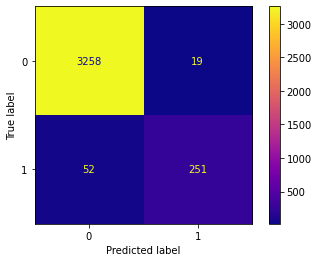

In [21]:
sk_cm = metrics.confusion_matrix(y_test, sk_pred)
sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
sk_disp.plot(cmap="plasma")
print('              | Sklearn )')
print('--------------+---------)')
print(f'Czułość       |{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]):9.4f}')
print(f'Specyficzność |{sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]):9.4f}')
print(f'Skuteczność   |{metrics.accuracy_score(sk_pred, y_test):9.4f}')
print(f'BACC          |{metrics.balanced_accuracy_score(sk_pred, y_test,adjusted=False):9.4f}')

### Porównanie głębokość a skuteczność

In [22]:
depths= [2, 4, 8, 16, 32, 64, 128, 256, 512]
depths = np.linspace(1,500,50)
ans = []
for depth in depths:
    sk_time = time.perf_counter()
    for i in range(10):
        htru_model.fit(X_train,y_train)
    sk_time = (time.perf_counter() - sk_time)/10
    ans.append([depth,htru_model.score(X_test,y_test), sk_time])
ans


[[1.0, 0.979608938547486, 0.10122662999999932],
 [11.183673469387756, 0.9801675977653631, 0.10106998999999917],
 [21.367346938775512, 0.9801675977653631, 0.10071432999999956],
 [31.551020408163268, 0.9801675977653631, 0.101005600000002],
 [41.734693877551024, 0.9801675977653631, 0.10057378999999855],
 [51.91836734693878, 0.9801675977653631, 0.10081089999999904],
 [62.102040816326536, 0.9801675977653631, 0.10215503000000012],
 [72.28571428571429, 0.979608938547486, 0.10051227000000154],
 [82.46938775510205, 0.979608938547486, 0.10066241000000105],
 [92.6530612244898, 0.979608938547486, 0.10107603000000154],
 [102.83673469387756, 0.979608938547486, 0.10368881999999928],
 [113.02040816326532, 0.9801675977653631, 0.10270447999999988],
 [123.20408163265307, 0.979608938547486, 0.10245496000000003],
 [133.38775510204084, 0.9801675977653631, 0.10234233999999845],
 [143.57142857142858, 0.9801675977653631, 0.10240486000000146],
 [153.75510204081633, 0.979608938547486, 0.10053029999999978],
 [163

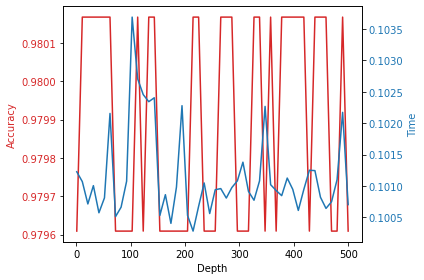

In [24]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Depth')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(ans[:,0], ans[:,1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Time', color=color)  # we already handled the x-label with ax1
ax2.plot(ans[:,0], ans[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Wnioski
- wybierając algorytm na podstawie którego wyślemy sonde do badania pulsara bardziej zacleży nam na skyteczności algorytmu niż na czasie jego wykonania. Czas budowy sondy i tak będzie wielokrotnie dłuższy nich czas wykonania niezoptymalizowanego modelu
- Czas wykonania dla mojego algorytmu rośnie wraz z głębokością drzewa, ma to związek z iteracją po całym zbiorze treningowym